In [3]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna

#automl
from pycaret.regression import *

In [9]:
path = 'C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/대구 교통사고/data'

train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
ss = pd.read_csv(path + '/sample_submission.csv')

train.drop(['ID'],axis=1, inplace=True)
test.drop(['ID'],axis=1, inplace=True)
#external


In [8]:
train.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,52세,경상,0,0,1,0,3


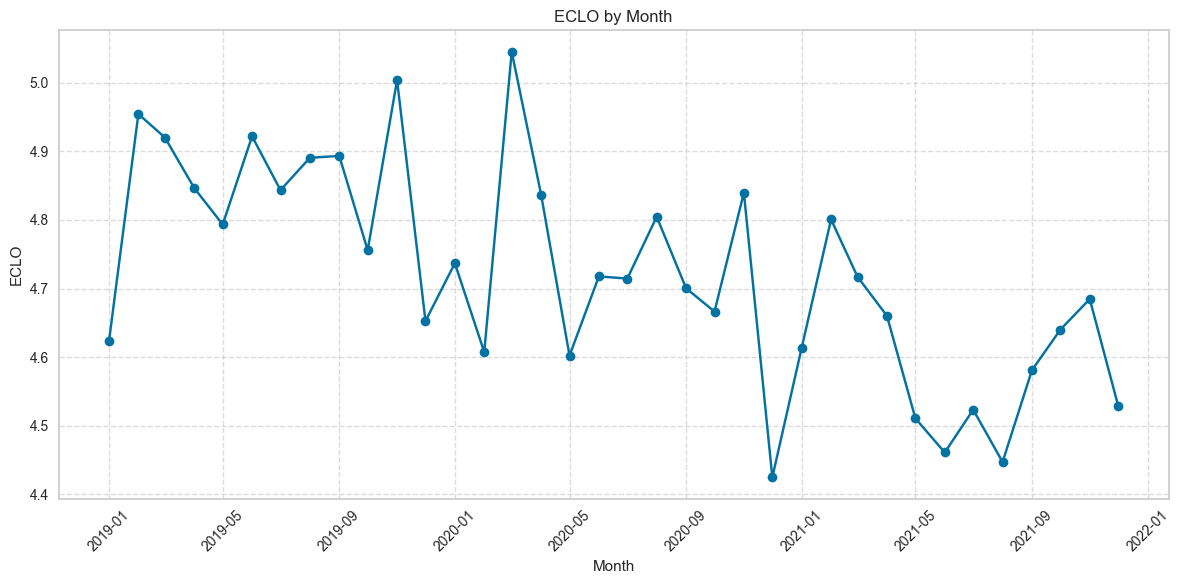

In [11]:
# '사고일시' 열을 datetime 형식으로 변환
train['사고일시'] = pd.to_datetime(train['사고일시'])

# 년월 열 추가
train['년월'] = train['사고일시'].dt.strftime('%y년%m월')

# 년월별 ECLO 평균 계산
monthly_avg = train.groupby('년월')['ECLO'].mean().reset_index()

# 년월을 정렬
monthly_avg['년월'] = pd.to_datetime(monthly_avg['년월'], format='%y년%m월')
monthly_avg = monthly_avg.sort_values('년월')

# 플롯 생성
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['년월'], monthly_avg['ECLO'], marker='o')

# 축 레이블 및 제목 설정
plt.xlabel('Month')
plt.ylabel('ECLO')
plt.title('ECLO by Month')

# x축 레이블 회전
plt.xticks(rotation=45)

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

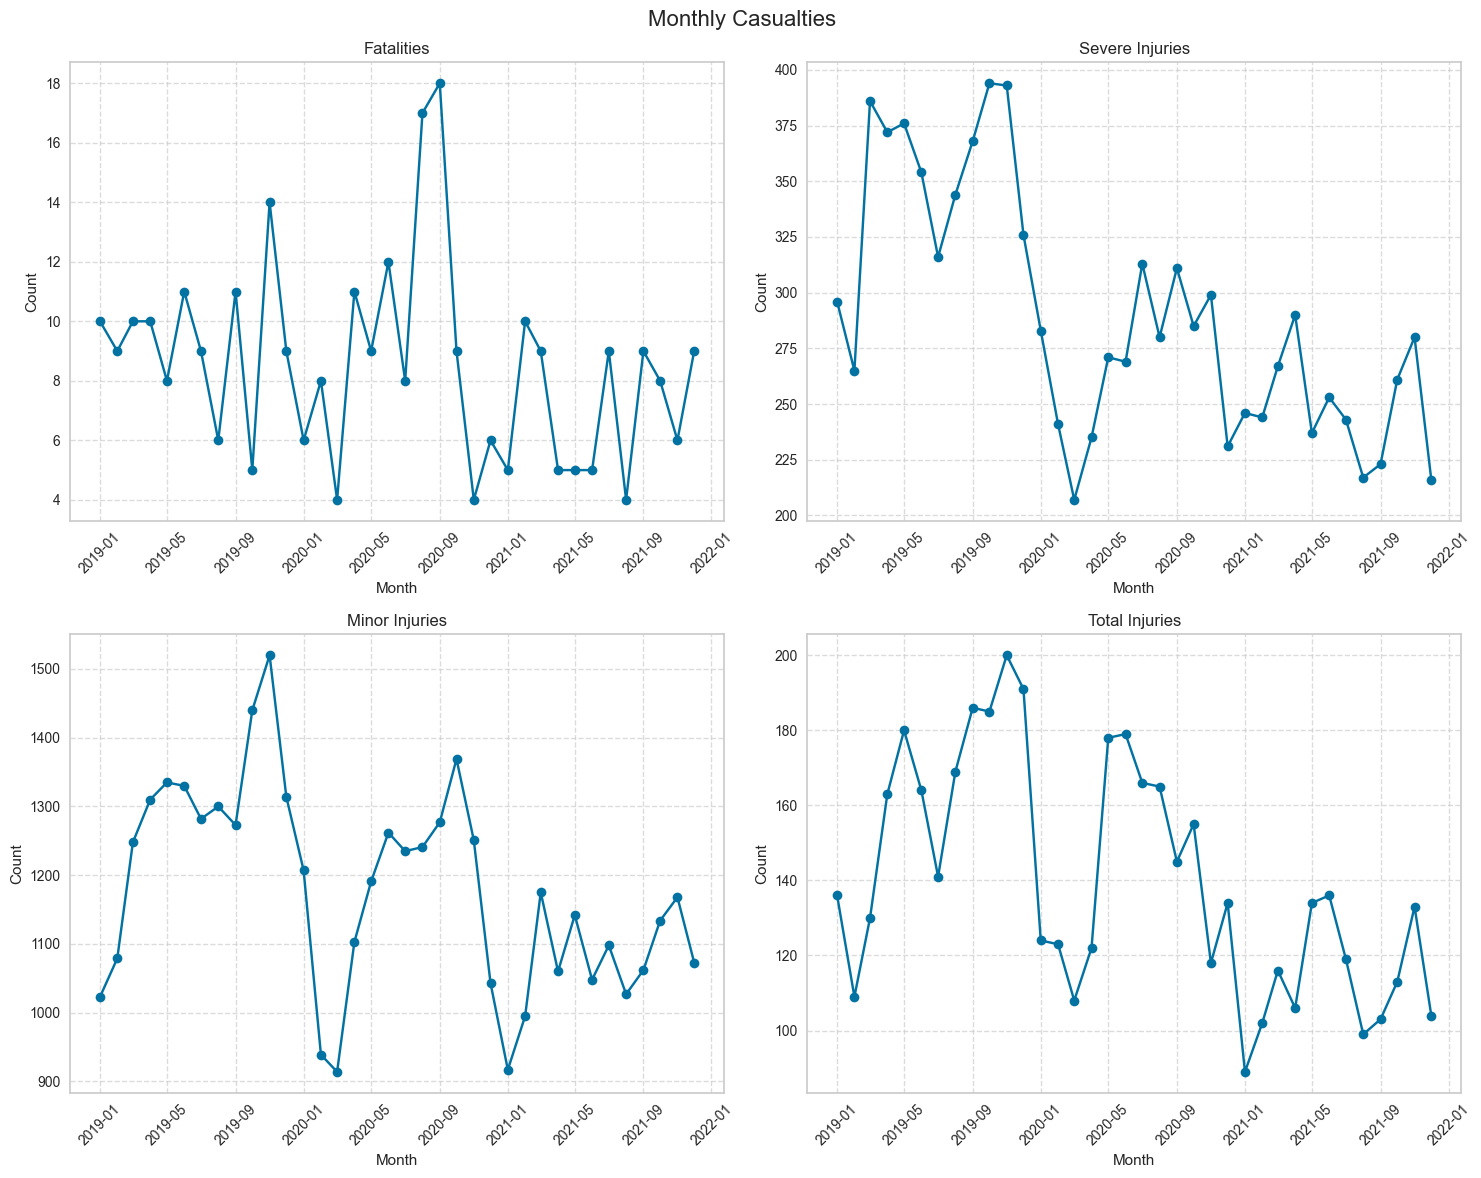

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# Sample data creation (replace this with your actual data loading)
df = train
# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Extract month and year
df['month_year'] = df['사고일시'].dt.to_period('M')

# Group by month and calculate the sum for each category
monthly_data = df.groupby('month_year').agg({
    '사망자수': 'sum',
    '중상자수': 'sum',
    '경상자수': 'sum',
    '부상자수': 'sum'
}).reset_index()

# Convert Period to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Monthly Casualties', fontsize=16)

# Flatten axs for easier iteration
axs = axs.flatten()

# Categories and their English translations
categories = {
    '사망자수': 'Fatalities',
    '중상자수': 'Severe Injuries',
    '경상자수': 'Minor Injuries',
    '부상자수': 'Total Injuries'
}

# Plot each category
for i, (kor, eng) in enumerate(categories.items()):
    axs[i].plot(monthly_data['month_year'], monthly_data[kor], marker='o')
    axs[i].set_title(eng)
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Count')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    axs[i].tick_params(axis='x', rotation=45)
    
    # Format x-axis to show month and year
    axs[i].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

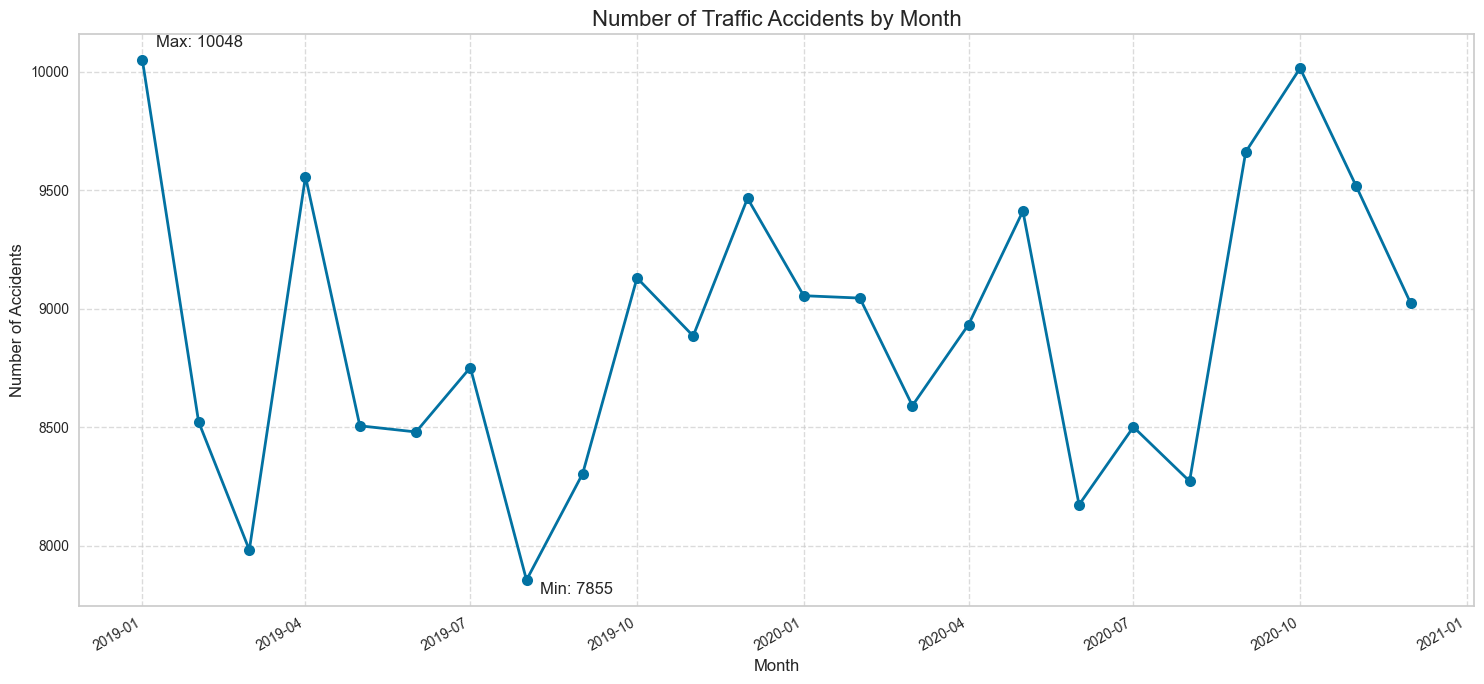

count       24.000000
mean      8903.708333
std        612.033850
min       7855.000000
25%       8495.750000
50%       8909.000000
75%       9425.500000
max      10048.000000
Name: accident_count, dtype: float64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, AutoDateLocator

# Sample data creation (replace this with your actual data loading)
date_range = pd.date_range(start='2019-01-01', end='2020-12-31', freq='D')
num_days = len(date_range)

data = {
    '사고일시': date_range,
    '사고ID': range(1, num_days + 1)  # Unique ID for each day
}
df = pd.DataFrame(data)

# Simulate random number of accidents for each day
df['accident_count'] = np.random.randint(100, 500, size=num_days)

# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Group by month and sum the accident counts
monthly_accidents = df.groupby(df['사고일시'].dt.to_period('M'))['accident_count'].sum().reset_index()
monthly_accidents['사고일시'] = monthly_accidents['사고일시'].dt.to_timestamp()

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(monthly_accidents['사고일시'], monthly_accidents['accident_count'], marker='o', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
plt.title('Number of Traffic Accidents by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x-axis
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add text annotations for the highest and lowest points
max_point = monthly_accidents.loc[monthly_accidents['accident_count'].idxmax()]
min_point = monthly_accidents.loc[monthly_accidents['accident_count'].idxmin()]

plt.annotate(f'Max: {max_point["accident_count"]}', 
             (max_point['사고일시'], max_point['accident_count']),
             xytext=(10, 10), textcoords='offset points', ha='left')
plt.annotate(f'Min: {min_point["accident_count"]}', 
             (min_point['사고일시'], min_point['accident_count']),
             xytext=(10, -10), textcoords='offset points', ha='left')

# Display the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(monthly_accidents['accident_count'].describe())

# Note: When using real data, replace the data creation part with:
# df = pd.read_csv('your_data_file.csv')
# df['사고일시'] = pd.to_datetime(df['사고일시'])
# monthly_accidents = df.groupby(df['사고일시'].dt.to_period('M')).size().reset_index(name='accident_count')
# monthly_accidents['사고일시'] = monthly_accidents['사고일시'].dt.to_timestamp()
# Then use 'monthly_accidents' in the plotting code as shown above

In [4]:
country = pd.read_csv('C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/대구 교통사고/data/external_open/countrywide_accident.csv')
country.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,2019-01-01 00,화요일,맑음,서울특별시 강서구 방화동,교차로 - 교차로횡단보도내,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,40세,경상,0,0,1,0,3
1,COUNTRYWIDE_ACCIDENT_000001,2019-01-01 00,화요일,맑음,경기도 포천시 소흘읍,교차로 - 교차로안,건조,차대차,기타,직진우회전진행방해,...,상해없음,이륜,남,20세,경상,0,0,1,0,3
2,COUNTRYWIDE_ACCIDENT_000002,2019-01-01 00,화요일,맑음,경기도 양주시 고암동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,17세,중상,0,1,0,0,5
3,COUNTRYWIDE_ACCIDENT_000003,2019-01-01 00,화요일,맑음,경기도 남양주시 다산동,기타 - 기타,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,10세,중상,0,2,0,0,10
4,COUNTRYWIDE_ACCIDENT_000004,2019-01-01 00,화요일,맑음,인천광역시 부평구 부평동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,승용,남,56세,경상,0,0,2,1,7


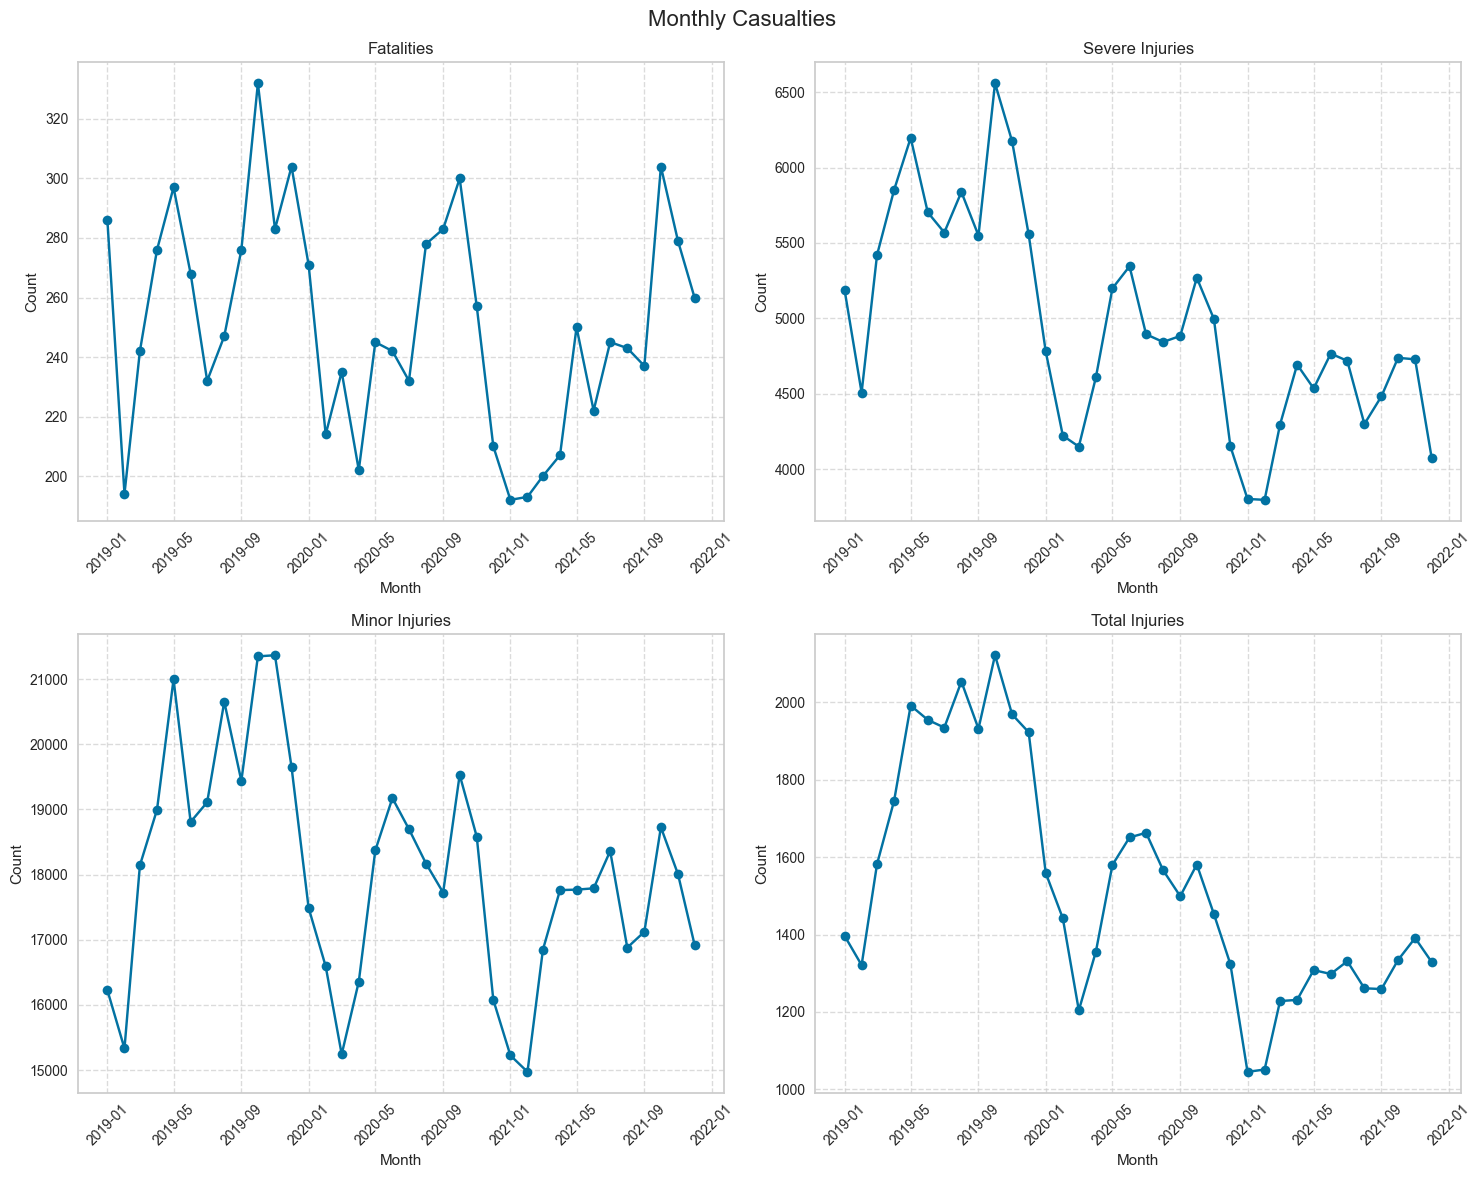

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

df = pd.DataFrame(country)

# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Extract month and year
df['month_year'] = df['사고일시'].dt.to_period('M')

# Group by month and calculate the sum for each category
monthly_data = df.groupby('month_year').agg({
    '사망자수': 'sum',
    '중상자수': 'sum',
    '경상자수': 'sum',
    '부상자수': 'sum'
}).reset_index()

# Convert Period to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Monthly Casualties', fontsize=16)

# Flatten axs for easier iteration
axs = axs.flatten()

# Categories and their English translations
categories = {
    '사망자수': 'Fatalities',
    '중상자수': 'Severe Injuries',
    '경상자수': 'Minor Injuries',
    '부상자수': 'Total Injuries'
}

# Plot each category
for i, (kor, eng) in enumerate(categories.items()):
    axs[i].plot(monthly_data['month_year'], monthly_data[kor], marker='o')
    axs[i].set_title(eng)
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Count')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    axs[i].tick_params(axis='x', rotation=45)
    
    # Format x-axis to show month and year
    axs[i].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

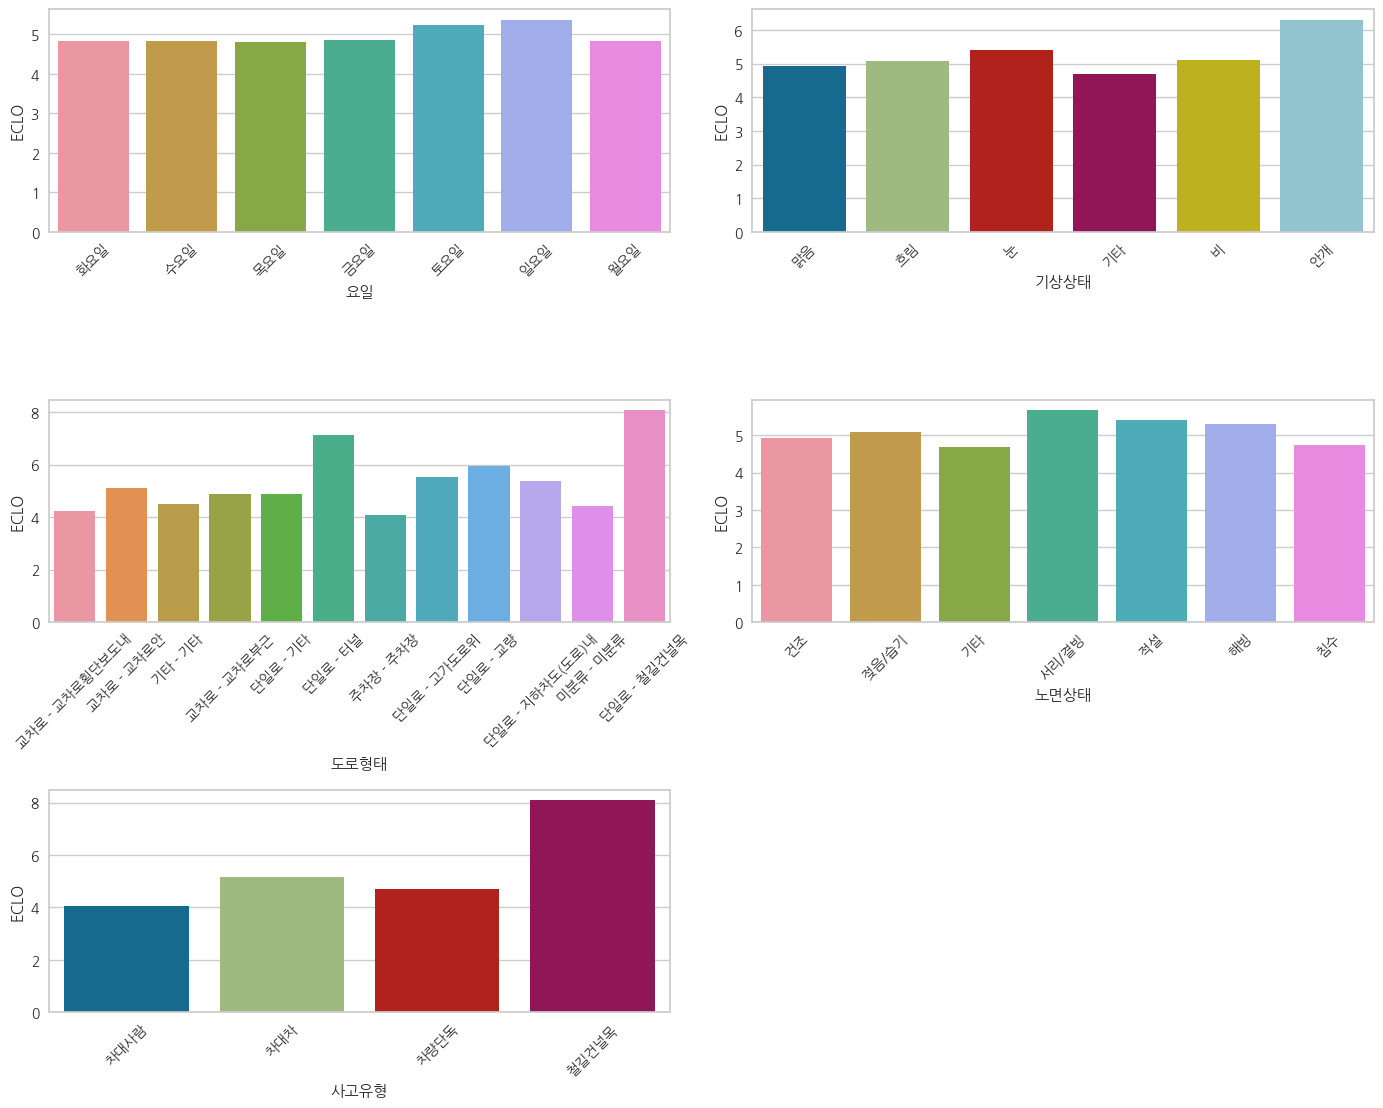

In [13]:
import matplotlib.font_manager as fm
font_path = 'C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/nanum-gothic/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

i = 0 
plt.figure(figsize=(14,26))
for col in ['요일',
 '기상상태',
 '도로형태',
 '노면상태',
 '사고유형']:
    i += 1
    plt.subplot(7,2,i)
    sns.barplot(x=country[col], y=country['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

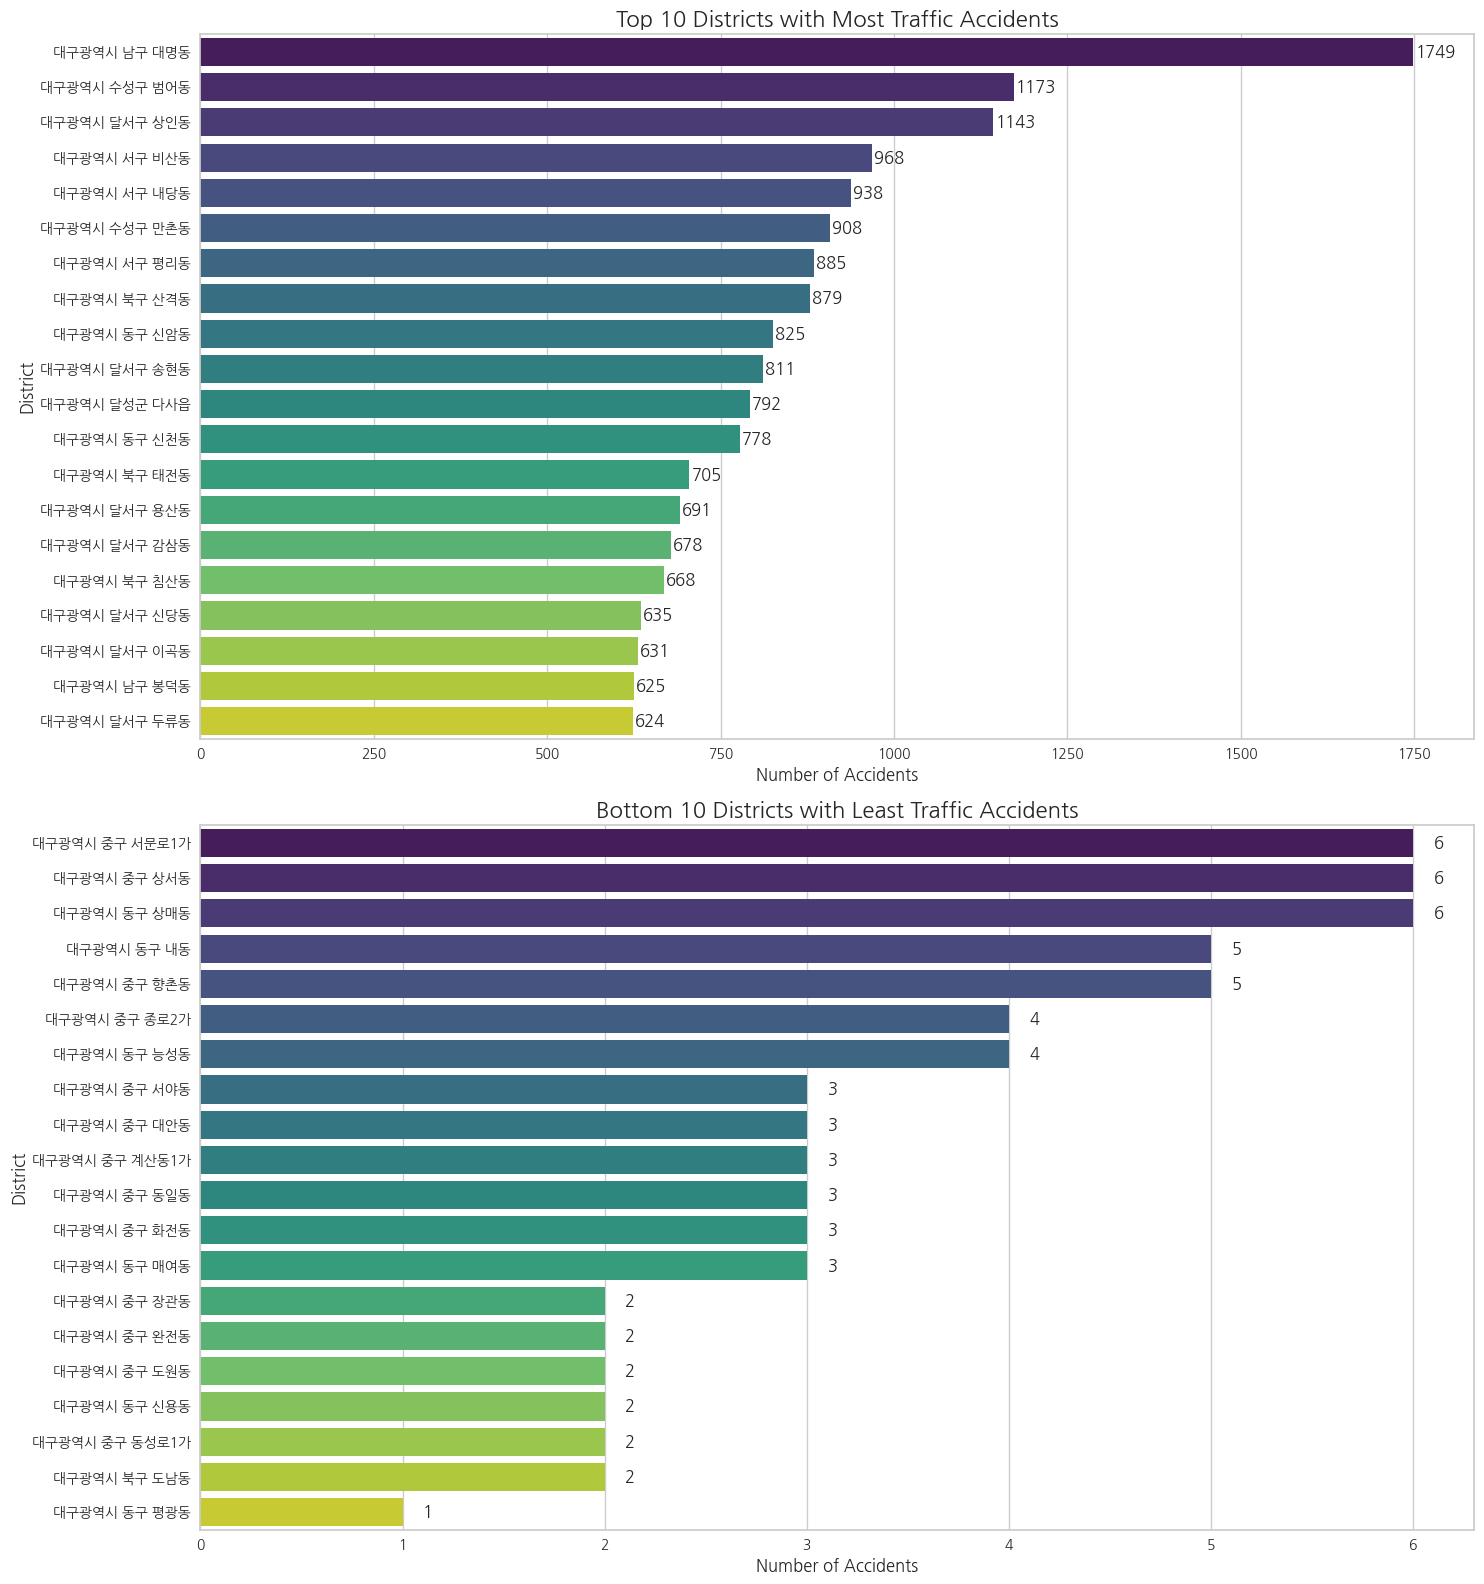

Summary statistics for all districts:
count     199.000000
mean      199.040201
std       272.210626
min         1.000000
25%        18.000000
50%        89.000000
75%       252.500000
max      1749.000000
Name: 시군구, dtype: float64

Total number of unique districts: 199

Top 10 districts with most accidents:
대구광역시 남구 대명동     1749
대구광역시 수성구 범어동    1173
대구광역시 달서구 상인동    1143
대구광역시 서구 비산동      968
대구광역시 서구 내당동      938
대구광역시 수성구 만촌동     908
대구광역시 서구 평리동      885
대구광역시 북구 산격동      879
대구광역시 동구 신암동      825
대구광역시 달서구 송현동     811
대구광역시 달성군 다사읍     792
대구광역시 동구 신천동      778
대구광역시 북구 태전동      705
대구광역시 달서구 용산동     691
대구광역시 달서구 감삼동     678
대구광역시 북구 침산동      668
대구광역시 달서구 신당동     635
대구광역시 달서구 이곡동     631
대구광역시 남구 봉덕동      625
대구광역시 달서구 두류동     624
Name: 시군구, dtype: int64

Bottom 10 districts with least accidents:
대구광역시 중구 서문로1가    6
대구광역시 중구 상서동      6
대구광역시 동구 상매동      6
대구광역시 동구 내동       5
대구광역시 중구 향촌동      5
대구광역시 중구 종로2가     4
대구광역시 동구 능성동      4
대구광역시 중구 서야동      3
대구광역시 중구 대안동      3
대구광

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded your data into a DataFrame called 'train'
# If not, uncomment and modify the following line:
# train = pd.read_csv('your_data_file.csv')

# Count the number of accidents for each district
district_counts = train['시군구'].value_counts()

# Select top 10 and bottom 10 districts
top_10 = district_counts.head(20)
bottom_10 = district_counts.tail(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

# Plot top 10 districts
sns.barplot(x=top_10.values, y=top_10.index, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Districts with Most Traffic Accidents', fontsize=16)
ax1.set_xlabel('Number of Accidents', fontsize=12)
ax1.set_ylabel('District', fontsize=12)

# Add value labels to the end of each bar for top 10
for i, v in enumerate(top_10.values):
    ax1.text(v + 3, i, str(v), va='center')

# Plot bottom 10 districts
sns.barplot(x=bottom_10.values, y=bottom_10.index, ax=ax2, palette='viridis')
ax2.set_title('Bottom 10 Districts with Least Traffic Accidents', fontsize=16)
ax2.set_xlabel('Number of Accidents', fontsize=12)
ax2.set_ylabel('District', fontsize=12)

# Add value labels to the end of each bar for bottom 10
for i, v in enumerate(bottom_10.values):
    ax2.text(v + 0.1, i, str(v), va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary statistics for all districts:")
print(district_counts.describe())

# Print the total number of unique districts
print(f"\nTotal number of unique districts: {len(district_counts)}")

# Print top 10 and bottom 10 districts
print("\nTop 10 districts with most accidents:")
print(top_10)
print("\nBottom 10 districts with least accidents:")
print(bottom_10)